# Installations and Imports

In [ ]:
!sudo apt-get update
!pip install 'imageio==2.4.0'
!sudo apt-get install -y xvfb ffmpeg
!pip3 install gymnasium[classic_control]

from IPython.display import clear_output
clear_output()

In [ ]:
import math
import base64
import random
import imageio
import IPython
import matplotlib
import numpy as np
from tqdm import tqdm
import gymnasium as gym
from itertools import count
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Utility functions for rendering evironment

In [ ]:
def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    
    return IPython.display.HTML(tag)

In [ ]:
def create_policy_eval_video(env, policy, filename, num_episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(device)
                action = policy(state)
                state, reward, terminated, truncated, _ = env.step(action)
                video.append_data(env.render())
                if terminated:
                    break
    return embed_mp4(filename)

# Replay Memory and Q-Network

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
# Complete the Q-Network below. 
# The Q-Network takes a state as input and the output is a vector so that each element is the q-value for an action.

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # ==================================== Your Code (Begin) ====================================
        self.fc1 = nn.Linear(n_observations, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)
        # ==================================== Your Code (End) ====================================

    def forward(self, x):
        # ==================================== Your Code (Begin) ====================================
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        # ==================================== Your Code (End) ====================================

# Policies

Now we define 2 policies. We use greedy policy for evaluation and e-greedy during training.

In [ ]:
# This function takes in a state and returns the best action according to your q-network.
# Don't forget "torch.no_grad()". We don't want gradient flowing through our network. 

# state shape: (1, state_size) -> output shape: (1, 1)  
def greedy_policy(qnet, state):
    # ==================================== Your Code (Begin) ====================================
    with torch.no_grad():
        q_values = qnet(state)
        best_action = q_values.argmax().item()
    return best_action
    # ==================================== Your Code (End) ====================================

In [ ]:
# state shape: (1, state_size) -> output shape: (1, 1)
# Don't forget "torch.no_grad()". We don't want gradient flowing through our network.

def e_greedy_policy(qnet, state, current_timestep):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * current_timestep / EPS_DECAY)
    # ==================================== Your Code (Begin) ====================================
    # With probability "eps_threshold" choose a random action 
    # and with probability 1-"eps_threshold" choose the best action according to your Q-Network.
    with torch.no_grad():
        q_values = qnet(state)
        if random.random() > eps_threshold:
            # Choose best action
            best_action = q_values.argmax().item()
        else:
            # Choose random action
            best_action = random.randint(0, q_values.shape[1] - 1)
    return best_action
    # ==================================== Your Code (End) ====================================

# Initial setup

In [ ]:
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.0005
LR = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v1", render_mode='rgb_array')
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
q_network = DQN(n_observations, n_actions)
target_network = DQN(n_observations, n_actions)
optimizer = optim.Adam(q_network.parameters(), lr=LR)
memory = ReplayMemory(10000)

create_policy_eval_video(env, lambda s: greedy_policy(q_network, s), "random_agent")

# Training

In [ ]:
num_episodes = 400
episode_returns = list()
episode_durations = list()
episode_losses = list()

for i_episode in tqdm(range(num_episodes)):

    # ==================================== Your Code (Begin) ====================================
    # 1. Start a new episode
    # 2. Run the environment for 1 step using e-greedy policy
    # 3. Add the (state, action, next_state, reward) to replay memory
    # 4. Optimize your q_network for 1 iteration
    #       4.1 Sample one batch from replay memory
    #       4.2 Compute predicted state-action values using q_network
    #       4.3 Compute expected state-action values using target_network (Don't forget "no_grad" because we don't want gradient through target_network)
    #       4.4 Compute loss function and optimize q_network for 1 step
    # 5. Soft update the weights of target_network
    #       θ′ ← τ θ + (1 −τ )θ′
    #       θ   is q_network weights
    #       θ′  is target_network weights            
    # 6. Keep track of the total reward for each episode to plot later

    # Start a new episode
    state, _ = env.reset()
    episode_reward = 0
    done = False
    episode_duration = 0
    episode_loss = 0
    
    while not done:
        # Run the environment for 1 step using e-greedy policy
        action = e_greedy_policy(q_network, torch.FloatTensor(state).unsqueeze(0), i_episode)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_duration += 1

        # Add the (state, action, next_state, reward) tuple to replay memory
        memory.push((state, action, next_state, reward, done))

        # Optimize the Q-Network for 1 iteration
        if len(memory) >= BATCH_SIZE:
            # Sample one batch from replay memory
            batch = memory.sample(BATCH_SIZE)
            states, actions, next_states, rewards, dones = zip(*batch)
            states = torch.from_numpy(np.asarray(states))
            next_states = torch.from_numpy(np.asarray(next_states))
            actions = torch.from_numpy(np.asarray(actions)).unsqueeze(1)
            rewards = torch.from_numpy(np.asarray(rewards))
            dones = torch.from_numpy(np.asarray(dones))

            # Compute predicted state-action values using Q-Network
            predicted_q_values = q_network(states).gather(1, actions).squeeze()

            # Compute expected state-action values using Target-Network
            with torch.no_grad():
                target_q_values = rewards + (~dones) * GAMMA * target_network(next_states).max(1)[0]

            # Compute loss function and optimize Q-Network for 1 step
            loss = F.smooth_l1_loss(predicted_q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            episode_loss += loss.item()

        # Soft update the weights of Target-Network
        for target_param, param in zip(target_network.parameters(), q_network.parameters()):
            target_param.data.copy_(TAU * param + (1 - TAU) * target_param)

        # Update current state and total reward
        state = next_state
        episode_reward += reward

    # Keep track of the total reward and duration for each episode
    episode_returns.append(episode_reward)
    episode_durations.append(episode_duration)
    episode_losses.append(episode_loss / BATCH_SIZE)

    # ==================================== Your Code (End) ====================================  

print('Complete')

100%|██████████| 400/400 [00:20<00:00, 19.38it/s]

Complete


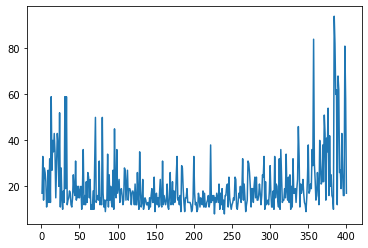

In [ ]:
plt.plot(range(1, num_episodes+1), episode_durations)

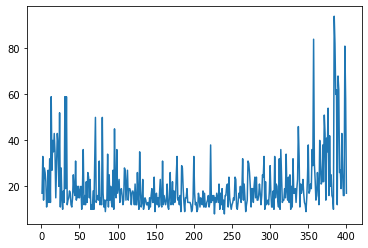

In [ ]:
plt.plot(range(1, num_episodes+1), episode_returns)

> As you can see, the episode durations and episode returns are equal due to the definition of envirinment.

> `Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted. The threshold for rewards is 475 for v1.`

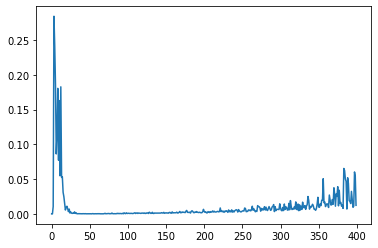

In [ ]:
plt.plot(range(len(episode_losses)), episode_losses)

In [ ]:
# Render trained model

create_policy_eval_video(env, lambda s: greedy_policy(q_network, s), "trained_agent")